# 02805 Social Graphs & Interactions Final Project
This notebook focuses on:

1) Pre-processing of the #nowplaying dataset to generate artist network

2) Generation of Spotify Artist network **based on collaborations**

3) Network Analysis of the aforementioned network, and comparing it to the #nowplaying dataset

In [1]:
# installing relevant packages
!pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 404 kB/s 
     |████████████████████████████████| 140 kB 30.3 MB/s 
     |████████████████████████████████| 248 kB 42.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [21]:
# general imports
import math
import re
import csv
import os
import json
import pickle
import random
from collections import Counter, defaultdict
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# spotify api imports
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# network building imports
import networkx as nx
from community import community_louvain
import fa2

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1) Pre-processing #nowplaying dataset

We are using a subset of the #nowplaying dataset. The #nowplaying dataset includes tracks which have been tweeted using the hashtags #nowplaying, #listento or #listeningto.

The dataset which we are going to use holds users, their playlists and the tracks contained in these playlists. Our interest is just in the tracks; what a particular user is listening to. Therefore, the playlistname column will be removed.

### Loading in #nowplaying dataset

In [ ]:
# load in the dataset
path = '/content/drive/MyDrive/University Materials/Business Analytics/Y3S1/02805 Social graphs & interactions/Data/Spotify Network/spotify_dataset.csv'
spotify_df = pd.read_csv(path, 
                         skiprows=1,
                         names=['user_id', 'artistname', 'trackname', 'playlistname'],
                         on_bad_lines='skip')

# drop any null values
spotify_df = spotify_df.dropna()
print("Initial dataset size:", len(spotify_df))
spotify_df.head()

Initial dataset size: 12867130


,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010


The `artistname` column contains the artist’s name extracted from the tweets with minimal pre-processing. Therefore, we should validate the column by checking if the values correspond to a single or multiple artists since a song can be performed by a single artist, multiple artists, or groups. 

We start with computing a set with all values of the `artistname`.

In [ ]:
# generate initial artists set
artists_set = set(map(lambda artist: str(artist).lower(), spotify_df.artistname))
len(artists_set)

282520

### Finding the unique artists from the dataset

The dataset contains 282520 unique values for the `artistname`. Now, we want to check how many of these values correspond to a single artist or collaborations.

One problem with the dataset is how the names of artists who collaborated on the same song are delimited. Since there is no standard delimitation, we split the `artistname` using multiple delimiters: "&", ",",  "/", "and", "feat.", "ft.", "featuring", "with" and check if it is a true collaboration and not the name of an artistic group. This isn't perfect, but we try to separate out as many artists as possible.

In short, if there was a collaboration, we split the artist names into individual elements of a list. If it wasn't a collaboration, we simply return the original artist.

In [ ]:
def get_true_artists():
  i = 0
  for idx, entry in spotify_df.iterrows():
    # check the progress of the function
    if i % 100000 == 0:
        print(i, "/", len(spotify_df))
    i += 1

    names = re.split('( and | & |, | \/ | feat. | feat | ft. | f. | featuring | with | - |; )', str(entry.artistname).lower())
    # check if it is a collaboration:
    if (set(names) & (artists_set)):
        # update the entry
        entry.artistname = list((set(names) & (artists_set)))
    else:
        entry.artistname = [str(entry.artistname).lower()]

In [ ]:
get_true_artists()

0 / 12867130
100000 / 12867130
200000 / 12867130
300000 / 12867130
400000 / 12867130
500000 / 12867130
600000 / 12867130
700000 / 12867130
800000 / 12867130
900000 / 12867130
1000000 / 12867130
1100000 / 12867130
1200000 / 12867130
1300000 / 12867130
1400000 / 12867130
1500000 / 12867130
1600000 / 12867130
1700000 / 12867130
1800000 / 12867130
1900000 / 12867130
2000000 / 12867130
2100000 / 12867130
2200000 / 12867130
2300000 / 12867130
2400000 / 12867130
2500000 / 12867130
2600000 / 12867130
2700000 / 12867130
2800000 / 12867130
2900000 / 12867130
3000000 / 12867130
3100000 / 12867130
3200000 / 12867130
3300000 / 12867130
3400000 / 12867130
3500000 / 12867130
3600000 / 12867130
3700000 / 12867130
3800000 / 12867130
3900000 / 12867130
4000000 / 12867130
4100000 / 12867130
4200000 / 12867130
4300000 / 12867130
4400000 / 12867130
4500000 / 12867130
4600000 / 12867130
4700000 / 12867130
4800000 / 12867130
4900000 / 12867130
5000000 / 12867130
5100000 / 12867130
5200000 / 12867130
5300000 

Pickle this new dataframe

In [ ]:
spotify_df.to_pickle(r'/content/drive/MyDrive/University Materials/Business Analytics/Y3S1/02805 Social graphs & interactions/Data/Spotify Network/spotify_dataset.pickle') 

Examine the new dataframe

In [ ]:
spotify_df = pd.read_pickle('/content/drive/MyDrive/University Materials/Business Analytics/Y3S1/02805 Social graphs & interactions/Data/Spotify Network/spotify_dataset.pickle') 

In [ ]:
spotify_df.head()

,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,[elvis costello],(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,[elvis costello],"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,[tiffany page],7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,[elvis costello],Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,[elvis costello],Alison,HARD ROCK 2010


Now, we should have lesser artists because we got rid of some artist names that were essentially extensions of an artist.

Eg. 'Elvis Costello' and 'Elvis Costello and the Attractions' are both now Elvis Costello.

In [ ]:
# update artists set; this is the new set of artists after doing some pre-processing to obtain each unique artist
artists_set = set([artist for artists in spotify_df.artistname for artist in artists])
len(artists_set)

241267

We want to know the popularity of each artist, based on the user sample. We compute the popularity as frequency of artist appearing over all the rows.

In [ ]:
# compute number of occurrences
popularity = Counter(x for xs in spotify_df.artistname for x in set(xs))
popularity.most_common(5)

[('daft punk', 36309),
 ('coldplay', 35626),
 ('radiohead', 31467),
 ('the rolling stones', 30826),
 ('kanye west', 30035)]

Display popularity distribution

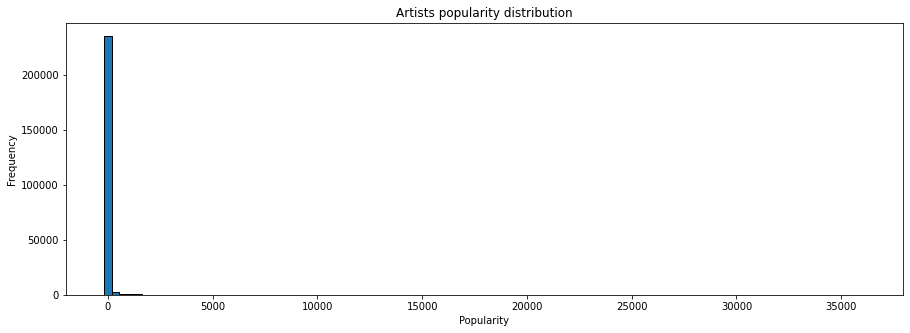

In [ ]:
values = list(popularity.values())
# return an array with histogram values and the bin edges 
hist, bin = np.histogram(values, bins=100)

plt.figure(figsize=(15, 5))
plt.title('Artists popularity distribution')
plt.bar(bin[:-1], hist, width=bin[1]-bin[0], ec='k', lw=1)
plt.xlabel("Popularity")
plt.ylabel("Frequency")

plt.show()

We notice that the distribution is tail-heavy, ie. there are a lot of artists that don't appear very frequently in the dataset. To counteract this skewness, we have opted to remove artists that appear in the dataset 50 times or less.

In [ ]:
# update artists set; this is the new set of artists that occur more than 50 times in the dataset
artists_set = set([key for key, val in popularity.items() if val > 50])

In [ ]:
remove_idx = []
i = 0
for idx, entry in spotify_df.iterrows():
    # check the progress of the function
    if i % 100000 == 0:
        print(i, "/", len(spotify_df))
    i += 1
    if not set(entry.artistname).issubset(artists_set):
        remove_idx.append(idx)

0 / 12867130
100000 / 12867130
200000 / 12867130
300000 / 12867130
400000 / 12867130
500000 / 12867130
600000 / 12867130
700000 / 12867130
800000 / 12867130
900000 / 12867130
1000000 / 12867130
1100000 / 12867130
1200000 / 12867130
1300000 / 12867130
1400000 / 12867130
1500000 / 12867130
1600000 / 12867130
1700000 / 12867130
1800000 / 12867130
1900000 / 12867130
2000000 / 12867130
2100000 / 12867130
2200000 / 12867130
2300000 / 12867130
2400000 / 12867130
2500000 / 12867130
2600000 / 12867130
2700000 / 12867130
2800000 / 12867130
2900000 / 12867130
3000000 / 12867130
3100000 / 12867130
3200000 / 12867130
3300000 / 12867130
3400000 / 12867130
3500000 / 12867130
3600000 / 12867130
3700000 / 12867130
3800000 / 12867130
3900000 / 12867130
4000000 / 12867130
4100000 / 12867130
4200000 / 12867130
4300000 / 12867130
4400000 / 12867130
4500000 / 12867130
4600000 / 12867130
4700000 / 12867130
4800000 / 12867130
4900000 / 12867130
5000000 / 12867130
5100000 / 12867130
5200000 / 12867130
5300000 

In [ ]:
spotify_df.drop(remove_idx, axis=0, inplace=True)

In [ ]:
len(spotify_df)

11445393

In [ ]:
# examine the first 5 rows
spotify_df.head()

,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,[elvis costello],(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,[elvis costello],"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,[elvis costello],Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,[elvis costello],Alison,HARD ROCK 2010
5,9cc0cfd4d7d7885102480dd99e7a90d6,[lissie],All Be Okay,HARD ROCK 2010


We now pickle this dataframe so in future runs of the notebook, we can simply load this in.

In [ ]:
spotify_df.to_pickle(r'/content/drive/MyDrive/University Materials/Business Analytics/Y3S1/02805 Social graphs & interactions/Data/Spotify Network/spotify_dataset.pickle') 

## 2) Generation of Spotify Artist Network
based off collaborations found from subset of #nowplaying dataset

In [ ]:
# load in the pickled dataframe
spotify_df = pd.read_pickle('/content/drive/MyDrive/University Materials/Business Analytics/Y3S1/02805 Social graphs & interactions/Data/Spotify Network/spotify_dataset.pickle') 

In [ ]:
# examine the first 5 rows
spotify_df.head()

,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,[elvis costello],(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,[elvis costello],"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,[elvis costello],Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,[elvis costello],Alison,HARD ROCK 2010
5,9cc0cfd4d7d7885102480dd99e7a90d6,[lissie],All Be Okay,HARD ROCK 2010


In [ ]:
artists_set = set([artist for artists in spotify_df.artistname for artist in artists])

In [ ]:
len(artists_set)

23682

In [ ]:
import networkx as nx
# construct artist network
artists_graph = nx.Graph()
artists_graph.add_nodes_from(artists_set)

We extract the collaborations from the spotify dataset, where we have a collaboration only if there are multiple entries in the list of artists associated with each track.

In [ ]:
collaborations = spotify_df.loc[map(lambda artists: len(artists) > 1, spotify_df.artistname)]
len(collaborations)

281626

Each artist is connected by their collaborations.

In [ ]:
i = 0
for _, entry in collaborations.iterrows():
    # check progress of the function
    if i % 100000 == 0:
        print(i, "/", len(collaborations))
    i+=1
    for a in range(len(entry.artistname) - 1):
        for b in range(a+1, len(entry.artistname)):
            artists_graph.add_edge(list(entry.artistname)[a], list(entry.artistname)[b])

0 / 281626
100000 / 281626
200000 / 281626


### Spotify Artist Network
Now that we have created the initial network of artists connected via their collaborations, we do further pre-processing of the graph.

We decided to:
- Remove the isolated nodes (artists without collaborations)
- Extract the largest component and use it as our artist network

In [ ]:
artists_graph.remove_nodes_from(list(nx.isolates(artists_graph)))
Gcc = sorted(nx.connected_components(artists_graph), key=len, reverse=True)
artists_graph = artists_graph.subgraph(Gcc[0])

print("number of nodes:", artists_graph.number_of_nodes())
print("number of edges:", artists_graph.number_of_edges())

number of nodes: 4819
number of edges: 10418


### Getting additional information from Spotify API about each song
In this section, we get more information about each artist. Namely, we obtain the Spotify ID (which can be used to check if the artist is on Spotify), popularity, genres and related artists.

In [ ]:
artists_set = set(artists_graph.nodes())
data = {'artistname': list(artists_set),
        'id': [None] * len(artists_set),
        'popularity': [None] * len(artists_set),
        'genres': [None] * len(artists_set),
        'related_artists': [None] * len(artists_set)}
artists_df = pd.DataFrame(data)

In [ ]:
# load credentials
credentials = json.load(open('authorization.json'))
client_id = credentials['client_id']
client_secret = credentials['client_secret']

In [ ]:
def search_artist_spotify(artist):
    results = sp.search(q=artist.artistname, type='artist')

    for result in results['artists']['items']:
        # check if artist was found
        if result['name'].lower() == artist.artistname:
            artist.id = result["id"]
            artist.popularity = result["popularity"]
            artist.genres = result["genres"]
    
    return artist

In [ ]:
def get_related_artists_spotify(artist):
    results = sp.artist_related_artists(artist.id)

    related_artists=list()
    for result in results['artists']:
        if result['name'].lower() in set(artists_df.artistname):
            related_artists.append(result['name'].lower())
    artist.related_artists = related_artists

In [ ]:
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret,
    ))

i = 0
for _, artist in artists_df.iterrows():
    if i % 100 == 0:
        print(i, "/", len(artists_df))
    i += 1
    artist = search_artist_spotify(artist)

0 / 4819
100 / 4819
200 / 4819
300 / 4819
400 / 4819
500 / 4819
600 / 4819
700 / 4819
800 / 4819
900 / 4819
1000 / 4819
1100 / 4819
1200 / 4819
1300 / 4819
1400 / 4819
1500 / 4819
1600 / 4819
1700 / 4819
1800 / 4819
1900 / 4819
2000 / 4819
2100 / 4819
2200 / 4819
2300 / 4819
2400 / 4819
2500 / 4819
2600 / 4819
2700 / 4819
2800 / 4819
2900 / 4819
3000 / 4819
3100 / 4819
3200 / 4819
3300 / 4819
3400 / 4819
3500 / 4819
3600 / 4819
3700 / 4819
3800 / 4819
3900 / 4819
4000 / 4819
4100 / 4819
4200 / 4819
4300 / 4819
4400 / 4819
4500 / 4819
4600 / 4819
4700 / 4819
4800 / 4819


In [ ]:
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret,
    ), requests_timeout=10, retries=10)

i = 0
for _, artist in artists_df.iterrows():
    if i % 100 == 0:
        print(i, "/", len(artists_df))
    i += 1
    if artist.id != None:
        get_related_artists_spotify(artist)

0 / 4819
100 / 4819
200 / 4819
300 / 4819
400 / 4819
500 / 4819
600 / 4819
700 / 4819
800 / 4819
900 / 4819
1000 / 4819
1100 / 4819
1200 / 4819
1300 / 4819
1400 / 4819
1500 / 4819
1600 / 4819
1700 / 4819
1800 / 4819
1900 / 4819
2000 / 4819
2100 / 4819
2200 / 4819
2300 / 4819
2400 / 4819
2500 / 4819
2600 / 4819
2700 / 4819
2800 / 4819
2900 / 4819
3000 / 4819
3100 / 4819
3200 / 4819
3300 / 4819
3400 / 4819
3500 / 4819
3600 / 4819
3700 / 4819
3800 / 4819
3900 / 4819
4000 / 4819
4100 / 4819
4200 / 4819
4300 / 4819
4400 / 4819
4500 / 4819
4600 / 4819
4700 / 4819
4800 / 4819


### Remove artists that are not on Spotify
We remove the artists that are not found on Spotify (by the ID).

In [ ]:
# these are the artists that are not on Spotify
no_info = (list(artists_df[artists_df.id.isnull()].artistname) + list(artists_df[artists_df.genres.isnull()].artistname))

In [ ]:
len(no_info)

836

In [ ]:
# remove the nodes (artists) that are not on Spotify
artists_graph = nx.Graph(artists_graph) # unfreeze the graph
artists_graph.remove_nodes_from(list(no_info))
Gcc = sorted(nx.connected_components(artists_graph), key=len, reverse=True)
artists_graph = artists_graph.subgraph(Gcc[0])

print("number of nodes:", artists_graph.number_of_nodes())
print("number of edges:", artists_graph.number_of_edges())

number of nodes: 4064
number of edges: 8836


Save the network

In [ ]:
# save graph object to file
pickle.dump(artists_graph, open('spotify_artists_collab.pickle', 'wb'))

## 3) Network Analysis 
Here, we do some network analysis to answer some questions related to the artist's network statistics.

Load in the network

In [4]:
artists_graph = pickle.load(open('/content/drive/MyDrive/University Materials/Business Analytics/Y3S1/02805 Social graphs & interactions/Data/Spotify Network/spotify_artists_collab.pickle', 'rb'))

### Plot the network

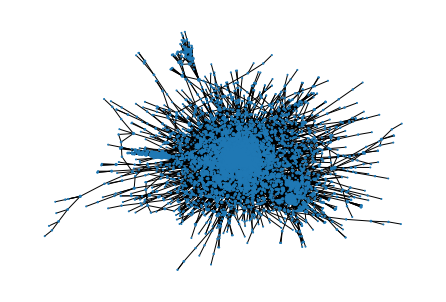

In [5]:
# plot the network using nx.draw
nx.draw(artists_graph, node_size=list(dict(artists_graph.degree()).values()))

### Nodes, Edges and Degrees

As mentioned earlier, each node represents **a Spotify artist from the #nowplaying dataset**. If **there is a collaboration between two artists**, we include an edge between the two nodes representing the artists.

Hence, the degree of the nodes represents the **number of collaborations** an artist has with other artists.

### Density of Graph

The density of a graph represents the ratio between the edges present in the graph and the maximum number of edges that a graph can contain.
Conceptually, this gives us an idea of how dense our artist graph is in terms of edge connectivity.

In [ ]:
nx.density(artists_graph)

0.001070249863856853

We observe that the density of the graph is very low, which tells us that the artists graph is not very dense ie. artists don't really collaborate as much as they could. This makes sense as an artist is likely to be selective with picking their collaborators as not all genres are able to mesh well with each other. The selective and intentional nature of collaboration would hence lead to a low artist network graph density.

### Degree distribution

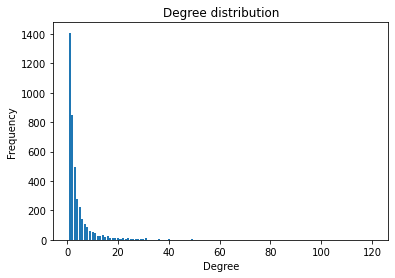

In [53]:
# Plot degree distribution
degree = list(dict(artists_graph.degree()).values())
hist, bin = np.histogram(degree, bins=range(min(degree), max(degree))) # return an array with histogram values and the bin edges 

# f, ax = plt.subplots(1, 2, figsize=(15,5))
plt.title('Degree distribution')
plt.bar(bin[:-1], hist)
plt.xlabel("Degree")
plt.ylabel("Frequency")

plt.show()

Here, we observe that most of the nodes have low degrees, some of them have a moderate degree, and a few nodes that have very high degrees. This means that most of the artists have few collaborations, while some artists have a higher number of collaborations, and a few artists have many collaborations (hubs).

We also investigate the mean, median, mode, maximum and minimum degrees.

In [ ]:
# churn out a pandas dataframe that gives us information on the various summary statistics of degrees in the network
graph_degree_statistics = pd.DataFrame([[np.mean(degree), np.median(degree), stats.mode(degree)[0][0], max(degree), min(degree)]],
                                       columns='Mean Degree,Median Degree,Mode Degree,Maximum Degree,Minimum Degree'.split(','))
graph_degree_statistics

,Mean Degree,Median Degree,Mode Degree,Maximum Degree,Minimum Degree
0,4.348425,2.0,1,122,1


In [ ]:
# find which artist has the highest degree ie. most number of collaborations
sorted(artists_graph.degree, key=lambda x: x[1], reverse=True)[0]

('his orchestra', 122)

We observe that the mean degree is around 4.35, which indicates that on average, each artist has about 4 collaborations. This might not be the best metric to look at as we have outliers (hubs that have a very high degree/no. of collaborations). 

We also analyze the median degree, which tells us that at the 50th percentile, artists have about 2 collaborations. 

The most prominent number of collaborations is 1, meaning that most artists have one collaboration only.

We can also see that there is one artist with 122 collaborations. Out of curiosity, we take a look at who this artist is.

Looks like 'His Orchestra' is the artist with the most number of collaborations.

Finally, we see that the minimum number of collaborations is 1, which is expected as we removed all the isolated nodes in our pre-processing ie. the artists with no collaborations.

### Check if distribution obeys a power law
Here, we check if the degree distribution of the artist network obeys a power law. We are essentially checking if the artist network is a scale-free network.

A scale-free network is a network whose degree distribution follows a power law.
This means that the *logarithm of the probability of a node having a certain degree k* depends linearly on *the logarithm of degree k*, and the slope of a line representing the relationship is the power law coefficient γ.

When the power law coefficient γ is high, the number of nodes with high degree is snaller than the number of nodes with low degree.

A high value of γ represents a network in which the distribution of edges is fairer.

In [ ]:
# installing relevant packages
!pip install powerlaw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Calculating best minimal value for power law fit
The slope of the incoming degree distribution 3.571382196944492


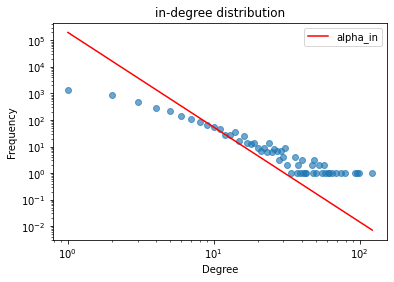

In [ ]:
from math import exp
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import powerlaw

degree_sequence = sorted(list(dict(artists_graph.degree()).values()), reverse=True)
alpha_in = powerlaw.Fit(degree_sequence).alpha
print("The slope of the incoming degree distribution", alpha_in)
degree_freq = Counter(degree_sequence)

x = np.log(np.array(list(degree_freq.keys())))
y = np.log(np.array(list(degree_freq.values())))

ymin, ymax = ([0, y.max()])
ymid = (ymin + ymax) / 2
xmin, xmax = ([0, x.max()])
xmid = (xmin + xmax) / 2

y1 = -alpha_in * (xmin - xmid) + ymid
y2 = -alpha_in * (xmax - xmid) + ymid

fig = plt.figure()
ax = plt.gca()
plt.scatter(degree_freq.keys(), degree_freq.values() , alpha=0.65)
ax.plot(np.exp([xmin, xmax]), np.exp([y1, y2]), 'r', label="alpha_in")

plt.title("in-degree distribution")
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.loglog()
plt.legend()

Here, we observe that the artist network's degree distribution does indeed obey a power law. In other words, the artist network is a scale-free network.

The power law coefficient we obtained from our analysis is about 3.57.

Hence, the artist network follows the *small world regime* since degree exponent γ is greater than 3.

This means that the second moment of the degree, variance, is finite. Inherently, this tells us that the spread in terms of collaborations between artists is quantifiable and does not diverge.

The average distance between the artists also follows the *small world result* that's derived for random networks.

For scale-free networks where γ > 3, hubs continue to be present (as seen from some artists that have many collaborations). However, they are not sufficiently large and numerous to have a significant impact on the distance between the nodes.

This means that the distances between each artist in the network is larger compared to a network with a smaller degree exponent γ.

### Finding communities within the best partition
Here, we find the best partition that separates the network into groups or communities.

We then find the modularity of the best partition, and inspect the communities to derive meaningful insights.

In [12]:
from community import community_louvain
# compute the best partition
communities = community_louvain.best_partition(artists_graph, random_state=0) 
# we used random_state parameter so that the results can be reproduced
mod = community_louvain.modularity(communities, artists_graph)
print("modularity is", mod)

no_communities = len(Counter(communities.values()))
print("The Louvain algorithm had found", no_communities, "communities")

for community, count in Counter(communities.values()).most_common():
    print("The community", community, "has", count, "nodes")

modularity is 0.7266009358501098
The Louvain algorithm had found 48 communities
The community 0 has 575 nodes
The community 6 has 487 nodes
The community 3 has 371 nodes
The community 9 has 365 nodes
The community 1 has 158 nodes
The community 15 has 145 nodes
The community 2 has 139 nodes
The community 7 has 138 nodes
The community 12 has 131 nodes
The community 30 has 123 nodes
The community 10 has 106 nodes
The community 11 has 106 nodes
The community 17 has 93 nodes
The community 16 has 86 nodes
The community 19 has 85 nodes
The community 27 has 83 nodes
The community 23 has 69 nodes
The community 32 has 68 nodes
The community 18 has 67 nodes
The community 4 has 64 nodes
The community 29 has 61 nodes
The community 14 has 60 nodes
The community 20 has 58 nodes
The community 24 has 58 nodes
The community 13 has 56 nodes
The community 22 has 56 nodes
The community 31 has 54 nodes
The community 26 has 42 nodes
The community 25 has 33 nodes
The community 21 has 17 nodes
The community 34

We obtained a high modularity score of 0.727 for the best partition.

Modularity measures the strength of division of a network into communities, where a higher modularity implies better partition. Since we are computing the modularity score of the best partition, we are obtaining the maximum modularity.

Networks with high modularity have dense connections between the nodes within communities but sparse connections between nodes in different communities.

As such, we can conclude that the artist network is well-separated into various distinct communities where each community is made up of different artists that have collaborated extensively with other artists in that community.

We plot a barplot that shows us the number of artists in each community.





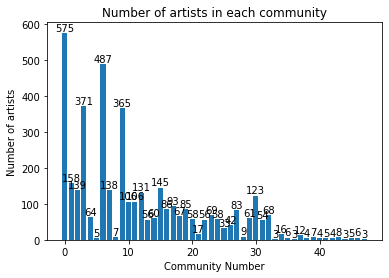

In [ ]:
# get the count of artists in each community
count_artists_community = list(Counter(communities.values()).values())
# get the community number
community_no = list(Counter(communities.values()).keys())
fig, ax = plt.subplots()

p = ax.bar(community_no, count_artists_community)

ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel('Number of artists')
ax.set_xlabel('Community Number')
ax.set_title('Number of artists in each community')
ax.bar_label(p)

plt.show()

### Plot the network using ForceAtlas2
- We color the different communities differently to show the modularity of the network.
- We also display each node differently depending on the degree of each node.

100%|██████████| 2000/2000 [02:10<00:00, 15.28it/s]


BarnesHut Approximation  took  33.48  seconds
Repulsion forces  took  89.02  seconds
Gravitational forces  took  0.13  seconds
Attraction forces  took  0.40  seconds
AdjustSpeedAndApplyForces step  took  2.47  seconds


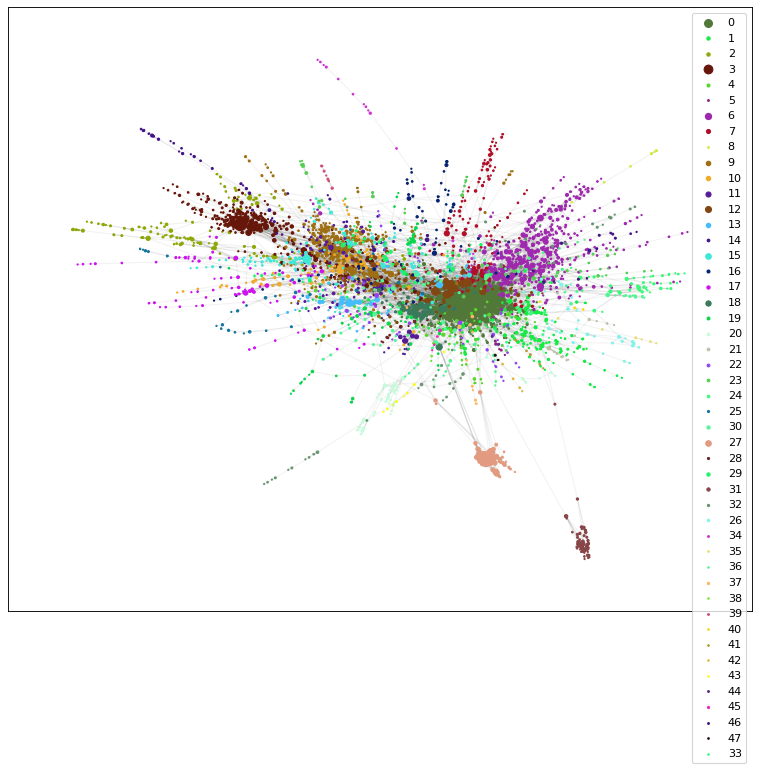

In [ ]:
forceatlas2 = fa2.ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=0.9,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=True,
                        gravity=0.6,

                        # Log
                        verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(artists_graph, pos=None, iterations=2000)
        
plt.figure(figsize=(12, 10), dpi=80)
communities_color = {} # keep a dict with colors for each community
nodelist_dc = []

for community in  Counter(communities.values()):
    communities_color[community] = np.array([random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)])
    nodelist = []
    
    for node in artists_graph:
        if node not in communities:
            nodelist_dc.append(node)
        elif communities[node] == community:
            nodelist.append(node)
    # display nodes from current artist community      
    nx.draw_networkx_nodes(artists_graph,
                           pos=positions,
                           nodelist=nodelist,
                           node_size=list(dict(artists_graph.degree(nodelist)).values()),
                           node_color=communities_color[community].reshape(1,-1), label=community)
nx.draw_networkx_edges(artists_graph, pos=positions, alpha=0.05)
plt.legend()

### Clustering Coefficient
Clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together.

Here, we examine the clustering coefficients of the artists in the artist network.

We first plot the distribution of the clustering coefficients across all the artists.

Then, we take a look at some of the summary statistics for the clustering coefficients.

In [8]:
# obtain clustering coefficient of all the nodes/artists in the network
clustering_coeff = nx.clustering(artists_graph)

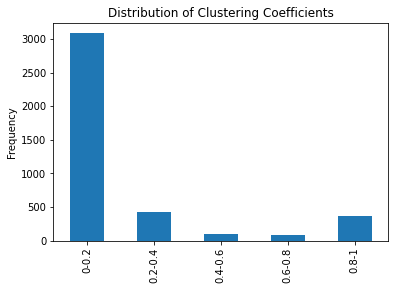

In [9]:
# plot the distribution of the clustering coefficients across all the artists
# first, we have to do binning since clustering coefficients are continuous values
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1']
fig, ax = plt.subplots()

pd.cut(list(clustering_coeff.values()), bins=bins, labels=labels, include_lowest=True).value_counts().plot(kind='bar')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Clustering Coefficients')

plt.show()

We observe that majority of the artists have a clustering coefficient within 0 and 0.2. This is undoubtedly a result of most of the artists having a clustering coefficient of 0. This means that the collaborators of these artists are not linked to each other at all.

On the contrary, we can see that there is a sizeable chunk of artists with clustering coefficient ranging from 0.8 - 1. This means that these artists are collaborating with other artists that are also likely collaborating with each other.

In [10]:
# churn out a pandas dataframe that gives us information on the various summary statistics of clustering coefficients in the network
clustering_coeff_values = list(clustering_coeff.values())
graph_clustering_coeff_statistics = pd.DataFrame([[np.mean(clustering_coeff_values), np.median(clustering_coeff_values), 
                                                  stats.mode(clustering_coeff_values)[0][0], max(clustering_coeff_values), min(clustering_coeff_values)]],
                                                  columns='Mean Clustering Coefficient,Median Clustering Coefficient,Mode Clustering Coefficient,Maximum Clustering Coefficient,Minimum Clustering Coefficient'.split(','))
graph_clustering_coeff_statistics

,Mean Clustering Coefficient,Median Clustering Coefficient,Mode Clustering Coefficient,Maximum Clustering Coefficient,Minimum Clustering Coefficient
0,0.170046,0.0,0.0,1.0,0


From this set of summary statistics, we can see that the average clustering coefficient is only 0.17. 

This means that on average, artists within the network tend to collaborate with artists that do not collaborate with each other. This finding measures up with the hypothesis that artists tend to be selective about their collaborations, choosing not to collaborate with many artists even if they have had mutual collaborations.

### Computing clustering coefficient within communities

In [18]:
# create a dataframe that stores clustering coefficient of an artist and community they belong to
cc_community_df = pd.DataFrame(index=communities.keys(), columns=['Clustering Coefficient', 'Community'])
for i in cc_community_df.index:
  cc_community_df.loc[i, :] = [clustering_coeff[i], communities[i]]
# display first 5 rows of the dataframe
cc_community_df.head()

,Clustering Coefficient,Community
chingy,0.25,0
torae,0,1
brian tyler,0,2
the gil evans orchestra,0,3
bounty killer,0.178571,4


Now, we take a closer look at the clustering coefficients of each individual community. 

We inspect the top 5 communities by average clustering coefficient.

In [28]:
# get the top 5 communities by average clustering coefficient
top_5_communities_cc = cc_community_df.groupby('Community').mean().sort_values(by='Clustering Coefficient', ascending=False)[:5]
top_5_communities_cc

,Clustering Coefficient
Community,
44,0.777778
39,0.547619
27,0.534907
13,0.346847
41,0.333333


To visualize our findings better, we plot the boxplot that details the summary statistics of the clustering coefficient for each of the top 5 communities via average clustering coefficient.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


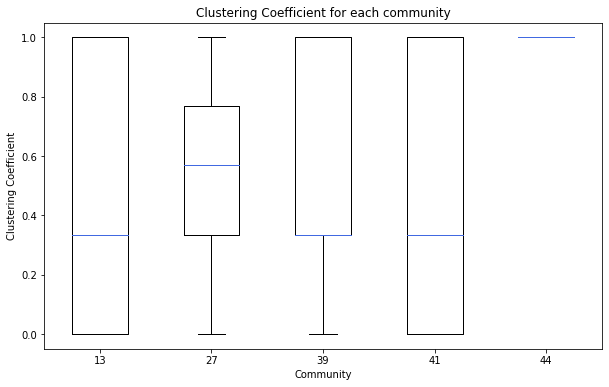

In [39]:
# split nodes in communities
community_split_cc = defaultdict(list)
for key, val in sorted(communities.items()):
    # get top 5 communities via average clustering coefficient
    if val in top_5_communities_cc.index:
      community_split_cc[val].append(key)
# dictionary of community : list of artists in that community for the top 5
# communities via average clustering coefficient
community_split_cc = dict(sorted(community_split_cc.items()))
# clustering coefficient for each community:
clustering_coeff_comm = {}
for key, values in community_split_cc.items():
    clustering_coeff_comm[key] = list(nx.clustering(artists_graph.subgraph(values)).values())
clustering_coeff_comm = dict(sorted(clustering_coeff_comm.items()))
fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(clustering_coeff_comm.values(),
           medianprops=dict(color='royalblue'))

ax.set_xticklabels(clustering_coeff_comm.keys())
ax.set_ylabel('Clustering Coefficient')
ax.set_xlabel('Community')
ax.set_title('Clustering Coefficient for each community')

plt.show()

Next, we inspect the top 5 communities by size.

In [29]:
# get the top 5 communities by size
top_5_communities_size = cc_community_df.groupby('Community').count().sort_values(by='Clustering Coefficient', ascending=False)[:5]
top_5_communities_size

,Clustering Coefficient
Community,
0,575
6,487
3,371
9,365
1,158


Likewise, we plot the boxplot that details the summary statistics of the clustering coefficient for each of the top 5 communities via size.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


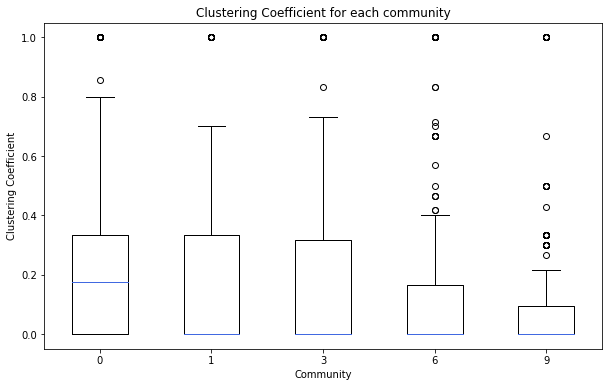

In [40]:
# split nodes in communities
community_split_size = defaultdict(list)
for key, val in sorted(communities.items()):
    # get top 5 communities via size
    if val in top_5_communities_size.index:
      community_split_size[val].append(key)
# dictionary of community : list of artists in that community for top 5 communities
# via size
community_split_size = dict(sorted(community_split_size.items()))
# clustering coefficient for each community:
clustering_coeff_comm = {}
for key, values in community_split_size.items():
    clustering_coeff_comm[key] = list(nx.clustering(artists_graph.subgraph(values)).values())
clustering_coeff_comm = dict(sorted(clustering_coeff_comm.items()))
fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(clustering_coeff_comm.values(),
           medianprops=dict(color='royalblue'))

ax.set_xticklabels(clustering_coeff_comm.keys())
ax.set_ylabel('Clustering Coefficient')
ax.set_xlabel('Community')
ax.set_title('Clustering Coefficient for each community')

plt.show()

When we compare the top 5 communities via average clustering coefficient and the top 5 communities via size, we observe that in general, the top 5 communities via clustering coefficient has higher median clustering coefficient than the top 5 communities via size. 

Unsurprisingly, this means that there are more collaborations within communities of artists where the artists' collaborators end up collaborating with each other, as compared to communities that have larger sizes.

### Correlation between clustering coefficient and degree

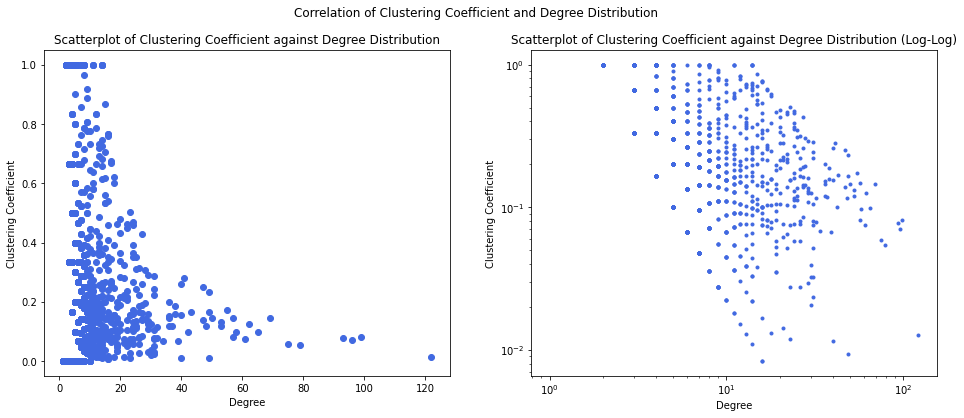

In [57]:
# Plot clustering coefficient vs degree distribution

fig, ax = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Correlation of Clustering Coefficient and Degree Distribution")
ax[0].scatter(degree, clustering_coeff_values, color='royalblue')
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("Clustering Coefficient")
ax[0].set_title("Scatterplot of Clustering Coefficient against Degree Distribution")

ax[1].loglog(degree, clustering_coeff_values,'.', color='royalblue')
ax[1].set_xlabel('Degree')
ax[1].set_ylabel("Clustering Coefficient")
ax[1].set_title("Scatterplot of Clustering Coefficient against Degree Distribution (Log-Log)")

plt.show()

We observe that if a node has a higher degree, its neighbors become more sparsely connected with each other.

This means the artists that have a lot of collaborations are collaborating with artists that do not collaborate amongst each other.

This is unsurprising as hubs (artists with lots of collaborations) may be linked to mostly nodes with low degree (artists with a few collaborations).

### Centrality measures: Betweenness Centrality
We opt to use betweenness centrality as it determines the importance of artists based on the number of times they occur within the shortest paths between other nodes.

In [46]:
# get betweenness centrality of each artist
betweenness_centrality = nx.betweenness_centrality(artists_graph)
# sort the betweenness centrality
betweenness_centrality = dict(sorted(betweenness_centrality.items()))

In [52]:
# average betweenness centrality for the entire artist network
np.mean(list(betweenness_centrality.values()))

0.0012808546250026307

We see that the average betweenness centrality for the entire artist network is only 0.00128. This means that most of the artists are not in the shortest paths between artists. This is expected given the large size of the scale-free network.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


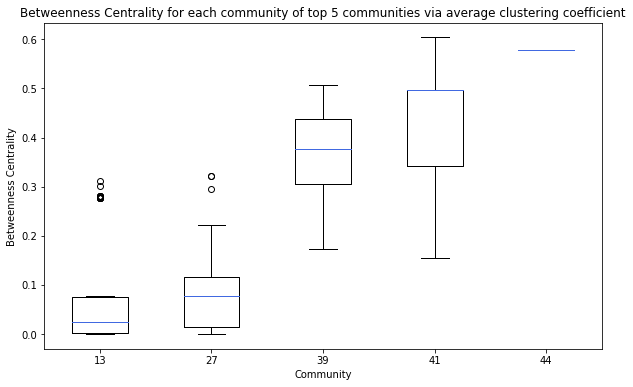

In [44]:
# betweenness centrality for each community of the top 5 via average clustering coefficient
betweenness_centrality_comm = {}
for key, values in community_split_cc.items():
    betweenness_centrality_comm[key] = list(nx.eigenvector_centrality(artists_graph.subgraph(values), max_iter=1000).values())
betweenness_centrality_comm = dict(sorted(betweenness_centrality_comm.items()))
fig, ax = plt.subplots(figsize=(10,6))

ax.boxplot(betweenness_centrality_comm.values(), medianprops=dict(color='royalblue'))
ax.set_xticklabels(betweenness_centrality_comm.keys())
ax.set_ylabel('Betweenness Centrality')
ax.set_xlabel('Community')
ax.set_title('Betweenness Centrality for each community of top 5 communities via average clustering coefficient')

plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


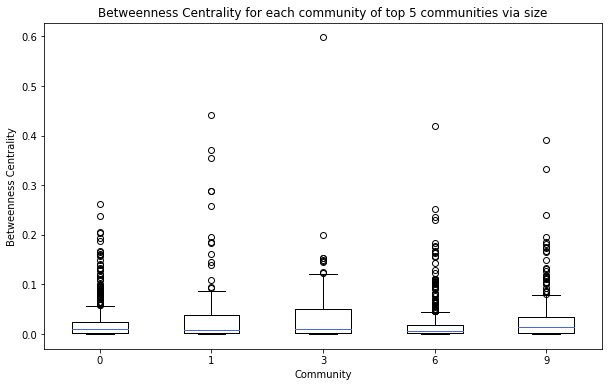

In [45]:
# betweenness centrality for each community of the top 5 via size
betweenness_centrality_comm = {}
for key, values in community_split_size.items():
    betweenness_centrality_comm[key] = list(nx.eigenvector_centrality(artists_graph.subgraph(values), max_iter=1000).values())
betweenness_centrality_comm = dict(sorted(betweenness_centrality_comm.items()))
fig, ax = plt.subplots(figsize=(10,6))

ax.boxplot(betweenness_centrality_comm.values(), medianprops=dict(color='royalblue'))
ax.set_xticklabels(betweenness_centrality_comm.keys())
ax.set_ylabel('Betweenness Centrality')
ax.set_xlabel('Community')
ax.set_title('Betweenness Centrality for each community of top 5 communities via size')

plt.show()

We observe that the betweenness centrality for top 5 communities via average clustering coefficient are generally significantly higher than the average betweenness centrality for the entire artist network.

For the top 5 communities via size, the betweenness centralities for each one of the communities are closer to the global betweenness centrality. 

### Correlation between centrality and degree distribution

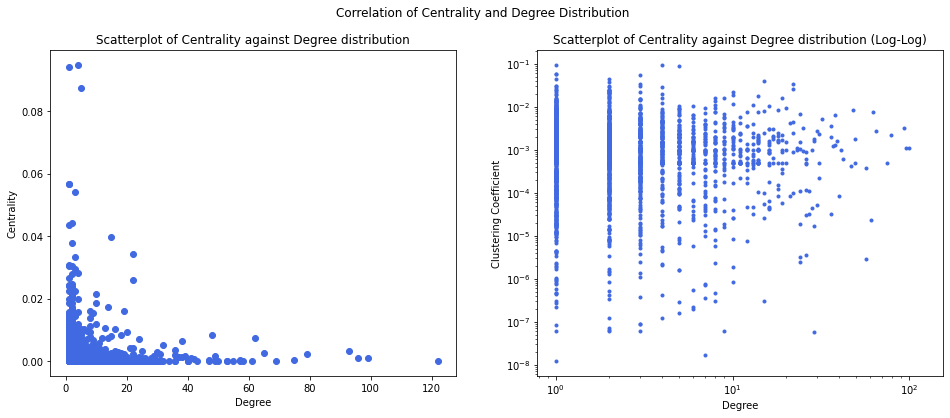

In [56]:
# Plot centrality and degree distribution

fig, ax = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Correlation of Centrality and Degree Distribution")
ax[0].scatter(degree, betweenness_centrality.values(), color='royalblue')
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("Centrality")
ax[0].set_title("Scatterplot of Centrality against Degree distribution")

ax[1].loglog(degree, list(betweenness_centrality.values()), '.', color='royalblue')
ax[1].set_xlabel('Degree')
ax[1].set_ylabel("Clustering Coefficient")
ax[1].set_title("Scatterplot of Centrality against Degree distribution (Log-Log)")

plt.show()

### Word Clouds of Communities
We use TF-IDF scores to determine the importance of each artist within the community. TF-IDF scores are only high if the artist appears frequently in one community but sparsely in others. Hence, it is the ideal metric for measuring the importance of an artist in the network.

### Let us now answer some interesting questions related to the network and the dataset we pre-processed earlier.

*Q: Do people listen to artists that collaborate with other artists more?*

Artists tend to collaborate with other artists. Not only do they get to try their hand at new genres, but they also massively increase their reach towards new audiences.

To answer this, we check if the artist's popularity (no. of occurrences in the dataset) and the artist's degree of distribution are correlated.

In [ ]:
# get the popularity of each artist from artist network
popularity = Counter(x for xs in spotify_df.artistname for x in set(xs)) # original popularity 
popularity_dict = {}
for artist in set(artists_graph.nodes):
  popularity_dict[artist] = popularity[artist]

In [ ]:
# get the degree of each artist in the network
degree_dict = dict(artists_graph.degree)

In [ ]:
# combine results into a dataframe for clear manipulation
popularity_degree_df = pd.DataFrame(index=popularity_dict.keys(), columns=['popularity', 'degree', 'community'])
for artist in popularity_dict:
  popularity_degree_df.loc[artist, :] = [popularity_dict[artist], degree_dict[artist], communities[artist]]

In [ ]:
# observe the first 5 rows of the dataframe
popularity_degree_df.head()

,popularity,degree,community
bessie smith,506,2,3
falsalarma,603,4,31
rita marley,79,1,4
oscar peterson trio,995,1,3
bliss,806,2,26


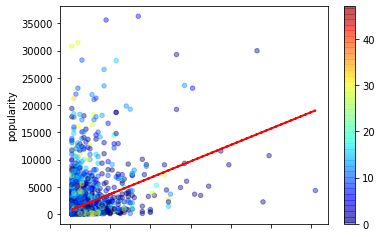

In [ ]:
# scatterplot between popularity and degree
popularity_degree_df.plot(kind='scatter', x='degree', y='popularity', alpha=0.4, c=popularity_degree_df['community'], cmap=plt.get_cmap('jet'), colorbar=True)
# add line of best fit to plot
gradient, intercept = np.polyfit(np.array(popularity_degree_df['degree'], dtype=float), np.array(popularity_degree_df['popularity'], dtype=float), 1)
plt.plot(popularity_degree_df['degree'], gradient * popularity_degree_df['degree'] + intercept, color='red', linestyle='--', linewidth=2)

We can clearly see that there is a positive correlation between the artist's degree in the network and their popularity. We cannot definitively determine whether one causes another, but one possible conclusion is that an artist that collaborates with other artists more (and has a higher degree) will have a higher popularity amongst fans as their songs would reach out to wider audiences.